In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Lets load some specific forecasting tools 
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# This will help us to see the classical method of determining P and Q orders


In [61]:
from pmdarima import auto_arima  # for grid searches(best ones)

In [6]:
df1 =pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq='D'
df1=df1[:120]    # Taking some part of the data

In [7]:
df2 = pd.read_csv('../Data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

# ARMA
- First thing we are gonna see is simple auto regressive moving average
- So we're going to first look at the stationary data set, determine P and Q orders
- run a forecasting ARMA model to fit the data.

- in practice, it's actually pretty rare to find stationary data with no trend and no seasonal component.
- if you just look at just the first four months of daily total female births, that data should be stationary enough in order to use it for ARMA. That why we took 120 days

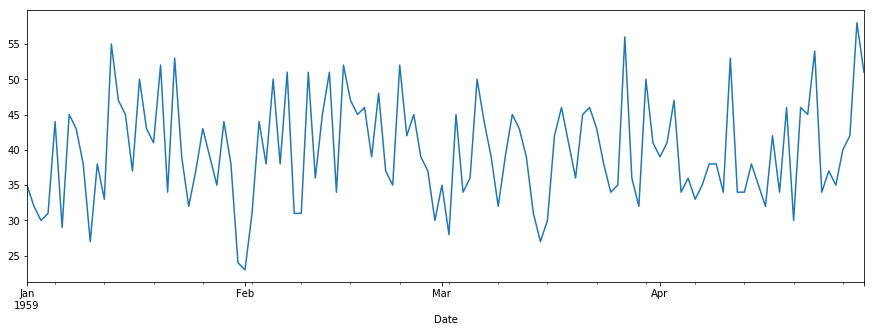

In [62]:
df1['Births'].plot(figsize=(15,5)).autoscale(axis='x',tight=True)

- So above we got some stationary looking data set
- and we saw that it picked up a mean value(40) and kinda trying to regress some sort of average value and it wont be able to simulate he noise

- Lets run the augmented dickey fuller test to confirm stationary 

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


- So our model should work for this 

In [34]:
import warnings
warnings.filterwarnings("ignore")

auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Wed, 09 Jun 2021   AIC                            822.741
Time:                        22:08:10   BIC                            839.466
Sample:                             0   HQIC                           829.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8162      0.108    368.841      0.000      39.605      40.028
ar.L1.y        1.8568      0.081     22.933      0.000       1.698       2.016
ar.L2.y       -0.8814      0.073    -12.030      0.000      -1.025      -0.738
ma.L1.y       -1.8634      0.109    -17.126      0.000      -2.077      -1.650
ma.L2.y        0.8634      0.108      8.020      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           -0.1582j            1.0652           -0.0237
AR.2            1.0533           +0.1582j            1.0652            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1583           +0.0000j            1.1583            0.0000
-----------------------------------------------------------------------------
"""

- Now we are gonna split
- you should set the length of your test set equal to your intended forecast size.
- So lets do a one month forecast

In [12]:
train =df1.iloc[:90]
test=df1.iloc[90:]

- Now lets create the model, fit the model and then see the results summary
- After that, we can forecast of the model for some predicted results 
- We have already decided that we should use ARMA(2,2) model

In [13]:
# This is our model and we will fit it next
model = ARMA(train['Births'],order=(2,2))

In [14]:
results = model.fit()

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Wed, 09 Jun 2021   AIC                            627.809
Time:                        22:07:43   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

- The above is same as given by auto_arima


- Lets obtain a month's worth of predicted values

In [16]:
start=len(train)
end=len(train)+len(test)-1

In [17]:
predictions = results.predict(start,end).rename('ARMA(2,2) Predictions')

In [18]:
test

,Births
Date,
1959-04-01,39
1959-04-02,41
1959-04-03,47
1959-04-04,34
1959-04-05,36
1959-04-06,33
1959-04-07,35
1959-04-08,38
1959-04-09,38


In [19]:
predictions

# All the predicted values are hoverig around the mean

1959-04-01    39.982222
1959-04-02    39.992614
1959-04-03    39.809830
1959-04-04    39.848174
1959-04-05    39.761538
1959-04-06    39.794255
1959-04-07    39.750500
1959-04-08    39.772833
1959-04-09    39.749661
1959-04-10    39.763667
1959-04-11    39.750991
1959-04-12    39.759432
1959-04-13    39.752354
1959-04-14    39.757337
1959-04-15    39.753335
1959-04-16    39.756244
1959-04-17    39.753964
1959-04-18    39.755651
1959-04-19    39.754347
1959-04-20    39.755323
1959-04-21    39.754575
1959-04-22    39.755138
1959-04-23    39.754708
1959-04-24    39.755033
1959-04-25    39.754785
1959-04-26    39.754972
1959-04-27    39.754830
1959-04-28    39.754938
1959-04-29    39.754856
1959-04-30    39.754918
Freq: D, Name: ARMA(2,2) Predictions, dtype: float64

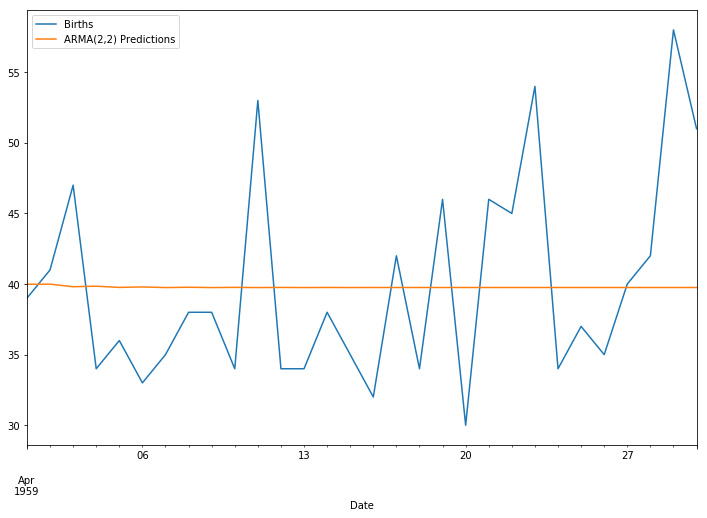

In [20]:
test['Births'].plot(figsize=(12,8),legend=True).autoscale(axis='x',tight=True)
predictions.plot(legend=True)

- Above we're reading here is that since our starting data set really exhibited no trend or no seasonal component. And we confirm that with the augmented Tickie Fuller test, this prediction actually makes sense, is essentially just showing you its forecasted average value.

- In fact, let's go ahead and see what the average value of the test results was.

In [21]:
test.mean()

Births    39.833333
dtype: float64

- we should recall that our model had never seen the test set

In [22]:
predictions.mean()

39.77743410878777

- Both are so close
- So our model is not being able to predict the noise that happened during these dates
- it was able to correctly predict extremely close to the actual mean average for that next month 
- 

# ARIMA

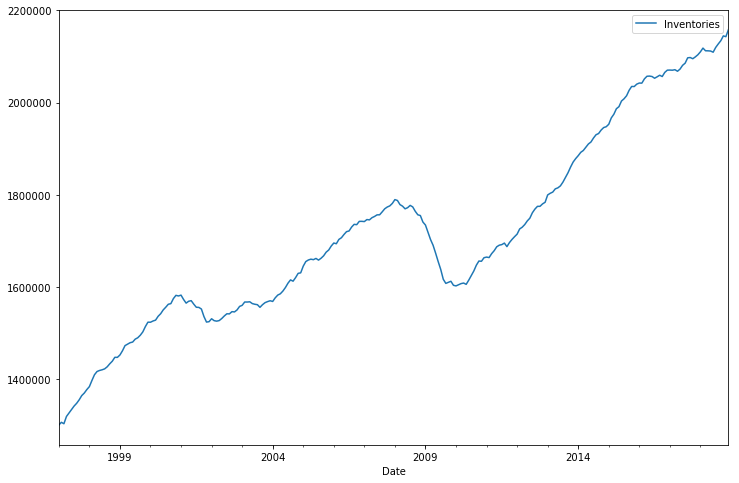

In [23]:
df2.plot(figsize=(12,8)).autoscale(axis='x',tight= True)

- We are gonna do some ETS now

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
df2.head(10)

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
1997-06-01,1334688
1997-07-01,1342310
1997-08-01,1348243
1997-09-01,1355839


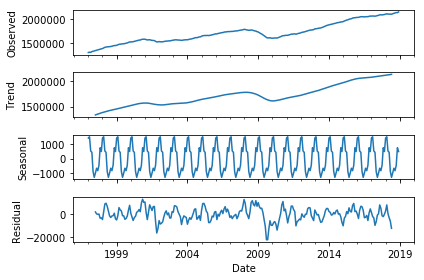

In [26]:
result = seasonal_decompose(df2['Inventories'],model='add')
result.plot();

- Domain of seasonal thing is very less compared to our observed data
- But still we can still run a full seasonal model. 
- But we are gonna ignore it for now 

In [27]:
import warnings
warnings.filterwarnings("ignore")
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Wed, 09 Jun 2021   AIC                           5228.505
Time:                        22:07:47   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

- So we should use an ARIMA(1,1,1) model.

- let's go ahead and run the Augmented Thicky Fuller test on that first difference.
- that is going to let us do is see if by running the augmented ticket for test that we can get the ACF and PACF plots to see if they agree.

In [28]:
from statsmodels.tsa.statespace.tools import diff

In [29]:
df2['Diff_1'] = diff(df2['Inventories'],k_diff=1)

In [30]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


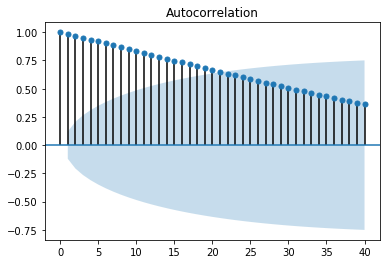

In [31]:
plot_acf(df2['Inventories'],lags=40);

- what we want to do is use this in conjunction with the partial autocorrelation plot.

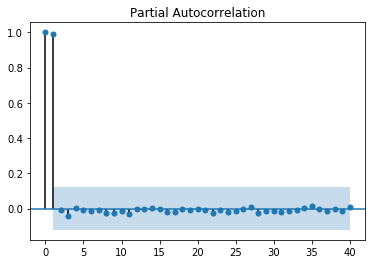

In [32]:
plot_pacf(df2['Inventories'],lags=40);

- Now how would I choose p and q values from these 2 plots
- d value is the easiest to choose as only thing we gotta do is keep differencing until data is stationary and we saw that with running our augmented dickey-fuller ttest, by one differencing we got stationary points 
- 

- What if we didn't have auto_arima we use different values of k_diff 

- And after 2-3 times use adf_test 
- But usually we choose the computer to do the work
- So we generally choose auto_arima function

- But we have a rule that:
- If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms.

In [33]:
# AR = 1
# I = 1
# MA = 0 or 1

In [35]:
# I want to do a stepwise fit with a trace so we can see what would happen if we ended up using this lower order(MA=0) MA model.
stepwise_fit=auto_arima(df2['Inventories'],start_p=0,start_q=0,max_p=2,max_q=2,seasonal=False,trace=True)

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.131 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.040 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.280 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.528, BIC=5247.389, Fit time=0.213 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.255 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.289, BIC=5247.150, Fit time=0.272 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.241 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Wed, 09 Jun 2021   AIC                           5228.505
Time:                        22:15:49   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

- Above, auto_arima thinks that ARIMA(1,1,1) is the best order

- But what if we choose a one one zero

- In (1,1,0), AIC is greater than AIC of (1,1,1), but we are trying to minimize the AIC value
- Many other models have AIC values kinda similar, but the priority is (1,1,1) beacause it has the lowest AIC

In [36]:
len(df2)

264

In [37]:
train= df2.iloc[:252]
test = df2.iloc[252:]

In [40]:
model= ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Wed, 09 Jun 2021   AIC                           4980.790
Time:                        22:23:11   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.871      2.378      0.018     561.671    5833.468
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [41]:
start = len(train)
end =len(train)+len(test)-1


predictions = results.predict(start=start, end=end,typ='levels').rename('ARIMA(1,1,1) Predictions')

- 'typ' is the type of predictions we are going to make, default is linear, 
- typ:
    - 'linear' : Linear prediction in terms of the differenced
      endogenous variables.
    - 'levels' : Predict the levels of the original endogenous
      variables.
- And generally we want the original endogenous variable/data. So, we are gonna use typ = 'levels'.
- An endogenous variable is a variable in a statistical model that's changed or determined by its relationship with other variables WITHIN the model.

In [44]:
predictions

2018-01-01    2.107148e+06
2018-02-01    2.110526e+06
2018-03-01    2.113886e+06
2018-04-01    2.117231e+06
2018-05-01    2.120561e+06
2018-06-01    2.123878e+06
2018-07-01    2.127184e+06
2018-08-01    2.130479e+06
2018-09-01    2.133764e+06
2018-10-01    2.137041e+06
2018-11-01    2.140311e+06
2018-12-01    2.143573e+06
Freq: MS, Name: ARIMA(1,1,1) Predictions, dtype: float64

In [45]:
test

,Inventories,Diff_1
Date,,
2018-01-01,2110158,6407.0
2018-02-01,2118199,8041.0
2018-03-01,2112427,-5772.0
2018-04-01,2112276,-151.0
2018-05-01,2111835,-441.0
2018-06-01,2109298,-2537.0
2018-07-01,2119618,10320.0
2018-08-01,2127170,7552.0
2018-09-01,2134172,7002.0


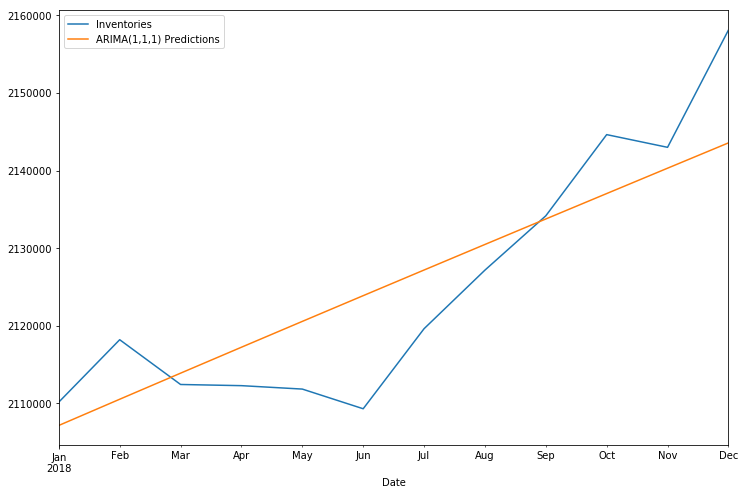

In [48]:
test['Inventories'].plot(legend=True,figsize=(12,8)).autoscale(axis='x',tight=True)
predictions.plot(legend=True).autoscale(axis='x',tight=True)

- So, whats going on in here?
    - Recall that we did have some minor seasonal component when we were checking out the ETS, but we ignored it since its scale was very low 
    - So we said that seasonal=False 
    
    - And we also did that when reading acf and pacf that we are just using normal p,d and q values 

- So we can say that our prediction above essentialy just showing a general trend and it may or may not be missing that yearly seasonality effect. 

In [50]:
from statsmodels.tools.eval_measures import rmse 


In [51]:
error=rmse(test['Inventories'],predictions)

In [52]:
error

7789.597211788464

- recall that we should be comparing this to kind of the average values of the test set to see kind of plus or minus how far off we are so we can compare the test mean.

In [53]:
test['Inventories'].mean()

2125075.6666666665

- Scale of error is a thing to notice as compared to actual scale of the values

In [54]:
predictions.mean()

2125465.270731611

# Lets forecast into the unknown future

In [55]:
model = ARIMA(df2['Inventories'],order=(1,1,1))

In [56]:
results = model.fit()

In [57]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Wed, 09 Jun 2021   AIC                           5228.505
Time:                        22:57:55   BIC                           5242.794
Sample:                    02-01-1997   HQIC                          5234.247
                         - 12-01-2018                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.Inventories     0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.Inventories    -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

In [58]:
fcast = results.predict(start=len(df2),end=len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

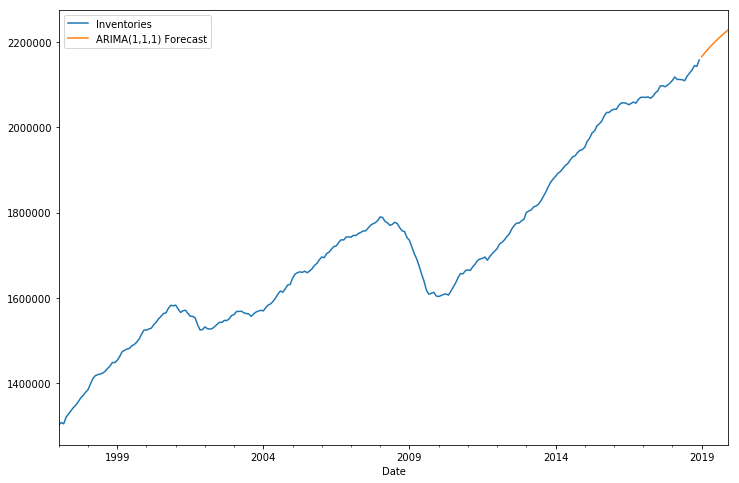

In [60]:
df2['Inventories'].plot(legend=True,figsize=(12,8)).autoscale(axis='x',tight=True)
fcast.plot(legend=True).autoscale(axis='x',tight=True)